# House Sales Analysis for House Hocket 

## 0.0 Business Problem 

A House Rocket é uma plataforma digital que tem como modelo de negócio, a compra e a venda de imóveis usando tecnologia.
 
O CEO da House Rocket gostaria de maximizar a receita da empresa encontrando boas oportunidades de negócio.

Sua principal estratégia é comprar boas casas em ótimas localizações com preços baixos e depois revendê-las posteriormente à preços mais altos. Quanto maior a diferença entre a compra e a venda, maior o lucro da empresa e portanto maior sua receita.

Entretanto, as casas possuem muitos atributos que as tornam mais ou menos atrativas aos compradores e vendedores e a localização e o período do ano também podem influenciar os preços.

Portanto, seu trabalho como Data Scientist é responder as seguintes perguntas:

- Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?
- Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?
- A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?


Para responder essas perguntas, num primeiro momento farei uma boa análise exploratória dos dados, a fim de ganhar insights que além de responder alguma das perguntas, ajudará a enxergar outros pontos que talvez equipe de negócio não sabia antes. 

Posteriormente, será será ajustado um modelo linear para aderessar questões quantitativas, como o incremento de preço. 

O modelo linear foi escolhido, pois ele é paramétrico e parte de um problema de otimização, permitindo observar a importância de cada variável no incremento de preço (podemos saber quanto, em média, o preço aumenta por cada aumento da unidade da variável).

### 0.1 Dataset Features 

- **id** :a notation for a house

- **date**: Date house was sold

- **price**: Price is prediction target

- **bedrooms**: Number of Bedrooms/House

- **bathrooms**: Number of bathrooms/bedrooms

- **sqft_living**: square footage of the home

- **sqft_lot**: square footage of the lot

- **floors** :Total floors (levels) in house

- **waterfront** :House which has a view to a waterfront

- **view**: Has been viewed

- **condition** :How good the condition is Overall

- **grade**: overall grade given to the housing unit, based on King County grading system

- **sqft_above** :square footage of house apart from basement

- **sqft_basement**: square footage of the basement

- **yr_built** :Built Year

- **yr_renovated** :Year when house was renovated

- **zipcode**:zip code

- **lat**: Latitude coordinate

- **long**: Longitude coordinate

- **sqft_living15** :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area

- **sqft_lot15** :lotSize area in 2015(implies-- some renovations)

Além desses dados, utilizaremos também dados do código postal de King County, que podem ser encontrados em: [King County Open Data](https://gis-kingcounty.opendata.arcgis.com/datasets/all-zipcodes-and-po-box-as-centroids-for-king-county-zipcode-all-point)

### 0.2 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display       import Image
from IPython.core.display  import HTML

from scipy import stats

### 0.3 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'seaborn-pastel' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_style('whitegrid')
    
def get_summary(numerical_attributes): # A dataframe object
    
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m
        
def mode(data): # A dataframe object
    
    lst_mode = []
    lst_column = []
    
    for column in data:
        
        lst_mode.append(data[column].mode()[0])
        lst_column.append(column)
        
        d = {'Column': lst_column, 'Mode': lst_mode}
        aux = pd.DataFrame(data = d)
                
    return aux

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.4 Load Data

In [4]:
pre_df = pd.read_csv('data/kc_house_data.csv', parse_dates = ['date'])
zip_df = pd.read_csv('data/zipcodes.csv')

### 0.5 Merge Data

In [5]:
df_zip = zip_df[['ZIP', 'PREFERRED_CITY']]

In [6]:
df_zip.rename(columns = {'ZIP':'zipcode', 'PREFERRED_CITY':'city'}, inplace = True)

/home/jvbf/anaconda3/envs/house-sales/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
df = pd.merge(pre_df,df_zip,on = 'zipcode')

## 1.0 Describe Data

In [8]:
df1 = df.copy()

In [9]:
df1.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,7129300520,4060000240,4058801670,2976800796,6874200960,4268200055,3969300030,3969300030,1678400105,2172000075
date,2014-10-13 00:00:00,2014-06-23 00:00:00,2014-07-17 00:00:00,2014-09-25 00:00:00,2015-02-27 00:00:00,2015-05-01 00:00:00,2014-07-23 00:00:00,2014-12-29 00:00:00,2015-02-12 00:00:00,2014-06-23 00:00:00
price,221900.0000,205425.0000,445000.0000,236000.0000,170000.0000,245000.0000,165000.0000,239900.0000,339000.000,290900.0000
bedrooms,3,2,3,3,2,3,4,4,4,2
bathrooms,1.0000,1.0000,2.2500,1.0000,1.0000,1.7500,1.0000,1.0000,1.500,2.0000
sqft_living,1180,880,2100,1300,860,1740,1000,1000,2390,1610
sqft_lot,5650,6780,8201,5898,5265,11547,7134,7134,7480,17600
floors,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.500,2.0000
waterfront,0,0,0,0,0,0,0,0,0,0
view,0,0,2,0,0,0,0,0,2,0


In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 22669
Number of Cols: 22


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22669 entries, 0 to 22668
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             22669 non-null  int64         
 1   date           22669 non-null  datetime64[ns]
 2   price          22669 non-null  float64       
 3   bedrooms       22669 non-null  int64         
 4   bathrooms      22669 non-null  float64       
 5   sqft_living    22669 non-null  int64         
 6   sqft_lot       22669 non-null  int64         
 7   floors         22669 non-null  float64       
 8   waterfront     22669 non-null  int64         
 9   view           22669 non-null  int64         
 10  condition      22669 non-null  int64         
 11  grade          22669 non-null  int64         
 12  sqft_above     22669 non-null  int64         
 13  sqft_basement  22669 non-null  int64         
 14  yr_built       22669 non-null  int64         
 15  yr_renovated   2266

In [12]:
cons = pd.DataFrame({'colunas' : df.columns,
                    'tipo': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unicos': df.nunique()})

cons['percentual'] = round(cons['missing'] / cons['size'],2)

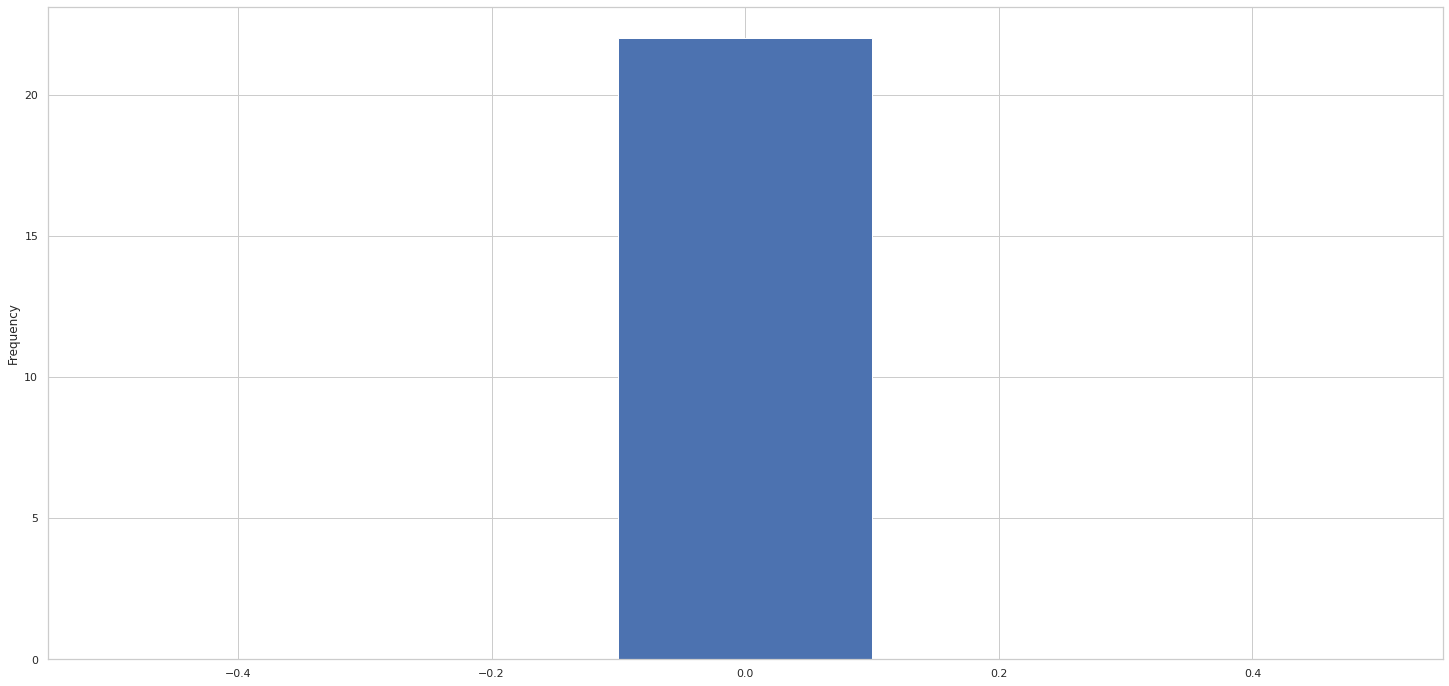

In [13]:
cons.percentual.plot.hist( bins = 5);

**Não existem dados faltantes no dataset**

In [14]:
df_aux = df1.drop(['id','date','lat','long', 'zipcode'], axis='columns')

num_attributes = df_aux.select_dtypes( include=['int64', 'float64'] )

In [15]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0,7700000.0,7625000.0,536201.260091,450000.00,362494.243969,4.024151,34.915778
1,bedrooms,0.0,33.0,33.0,3.373682,3.00,0.921593,1.936454,48.539051
2,bathrooms,0.0,8.0,8.0,2.119194,2.25,0.766044,0.494971,1.279914
3,sqft_living,290.0,13540.0,13250.0,2089.438264,1930.00,919.158330,1.453338,5.094978
4,sqft_lot,520.0,1651359.0,1650839.0,16520.716573,7708.00,45359.609179,12.513850,270.644290
5,floors,1.0,3.5,2.5,1.495236,1.50,0.537737,0.593451,-0.529538
6,waterfront,0.0,1.0,1.0,0.007190,0.00,0.084491,11.666142,134.110705
7,view,0.0,4.0,4.0,0.232785,0.00,0.763214,3.397306,10.894036
8,condition,1.0,5.0,4.0,3.409590,3.00,0.648924,1.034441,0.519031
9,grade,1.0,13.0,12.0,7.669549,7.00,1.178939,0.757885,1.152441


**Most commom values**

In [16]:
mode(num_attributes)

,Column,Mode
0,price,450000.0
1,bedrooms,3.0
2,bathrooms,2.5
3,sqft_living,1300.0
4,sqft_lot,5000.0
5,floors,1.0
6,waterfront,0.0
7,view,0.0
8,condition,3.0
9,grade,7.0


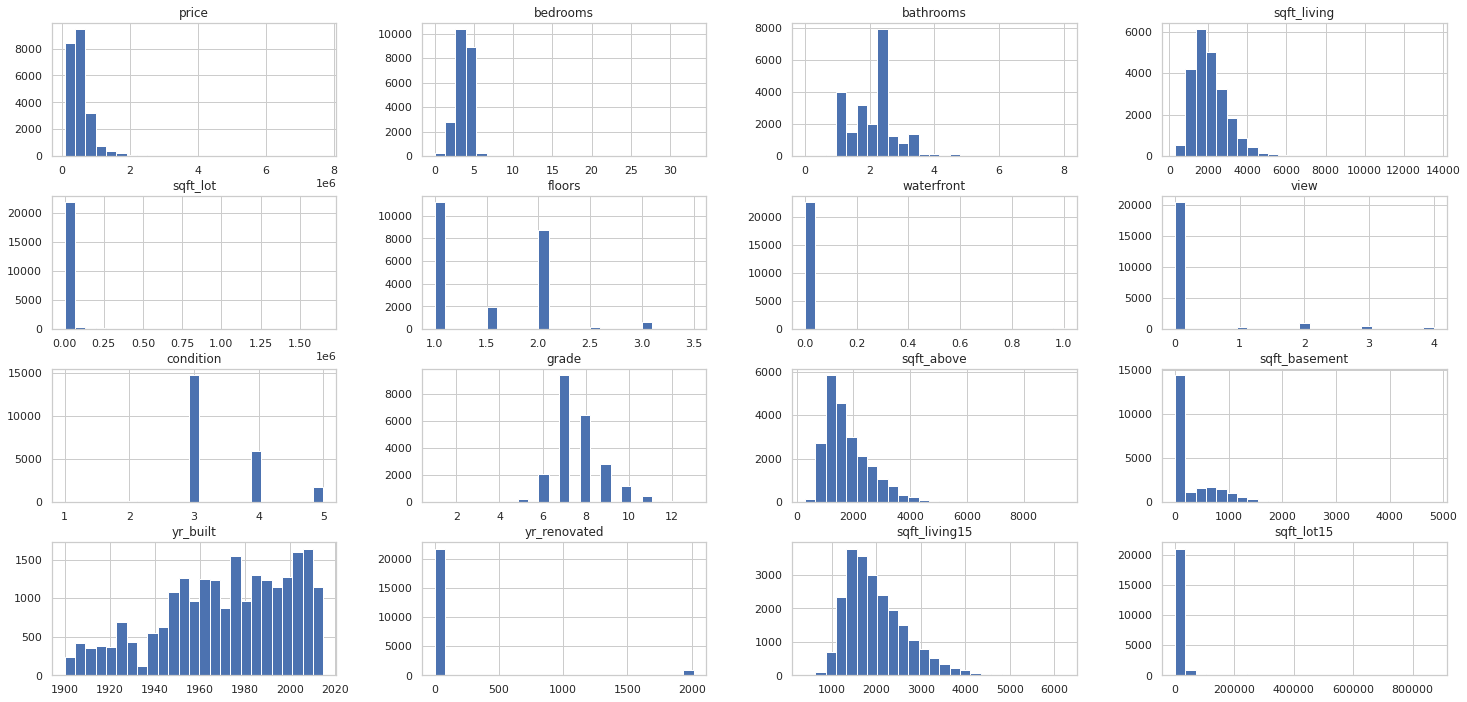

In [17]:
num_attributes.hist(bins = 25);

**Target**

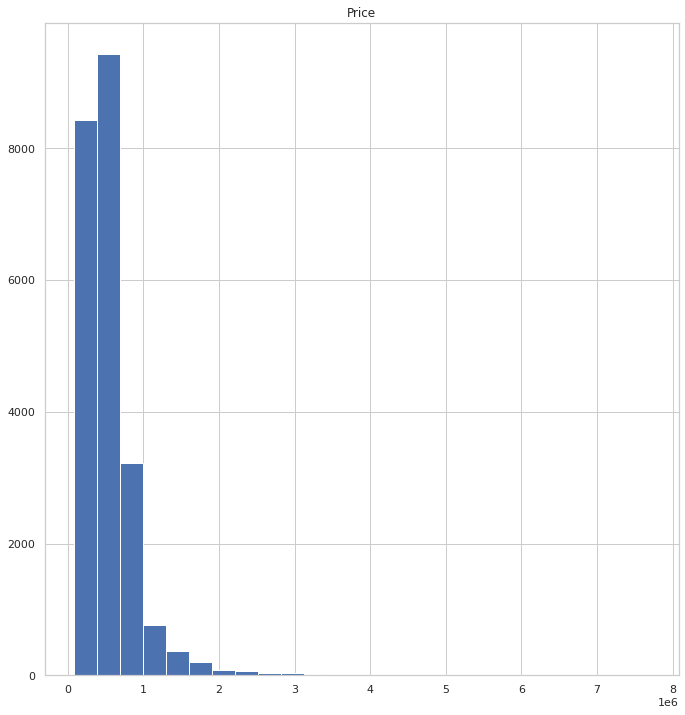

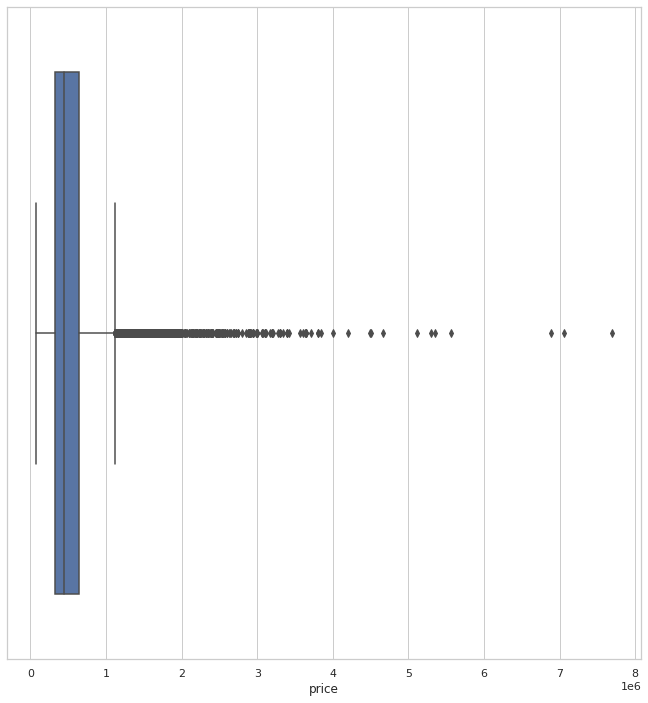

In [18]:
plt.subplot(1,2,1)
df['price'].hist(bins = 25)
plt.title('Price')
plt.show()

plt.subplot(1,2,2)
sns.boxplot(x = 'price', data = df);

**Categorical**

In [19]:
df1['waterfront'].value_counts()

0    22506
1      163
Name: waterfront, dtype: int64

In [20]:
df1['city'].value_counts()

SEATTLE          8977
RENTON           1597
BELLEVUE         1407
AUBURN           1263
KENT             1203
REDMOND           979
KIRKLAND          977
WOODINVILLE       942
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      590
ENUMCLAW          468
SAMMAMISH         441
SAMMAMIISH        359
SNOQUALMIE        310
KENMORE           283
MERCER ISLAND     282
NORTH BEND        221
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            118
BLACK DIAMOND     100
FALL CITY          81
MEDINA             50
Name: city, dtype: int64

## 2.0 Feature Engineering

In [21]:
df1 = df.copy()

### 2.1 Month and Year

In [22]:
df1['year'] = pd.DatetimeIndex(df['date']).year
df1['month'] = pd.DatetimeIndex(df['date']).month

In [23]:
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr' , 5:'Mai', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}

df1['month'] = df1['month'].map(month_dict)

### 2.2 Bathrooms and bedrooms

In order to understand better the data, we're going to create a new variable called "house_type".

This variable will work as follows:

- Houses with a bath/bed ratio greater than 1, will be labeled "robust house"
- Houses with a bath/bed ratio equal to 1, will be labeled "standard house"
- Houses with a bath/bed ratio less than 1, will be labeled "needy house"

The ideia behind this, is that we expect the bedrooms and bathrooms alone to have impact on the house price, but, maybe, a combination between these two adresses these impact more throughfully, once houses with more bathrooms than bedrooms implies in baths for guests. We'll test that assumption

We're also creating a variable called "house_ratio" witch is solely the bath/bed ratio we're gonna compute

In [24]:
df1['house_ratio'] = df1['bathrooms'] / df1['bedrooms']

df1['house_type'] = df1['house_ratio'].apply(lambda x: 'robust_house' if x > 1 else 'standard house' if x == 1 else 'needy house')

In [25]:
df1['house_ratio'].describe()

count    22662.000
mean           inf
std            NaN
min          0.000
25%          0.500
50%          0.625
75%          0.750
max            inf
Name: house_ratio, dtype: float64

In [26]:
df1 = df1.replace([np.inf, -np.inf], np.nan)

In [27]:
df1 = df1.dropna()

### 2.3 Square Feet Living

We're also going to create the sqft_living_change variable, witch is the **difference between the actual sqft_living area and sqft_living15 area**

In [28]:
df1['sqft_living_change'] = df1['sqft_living'] - df1['sqft_living15']

Text(0, 0.5, 'Price')

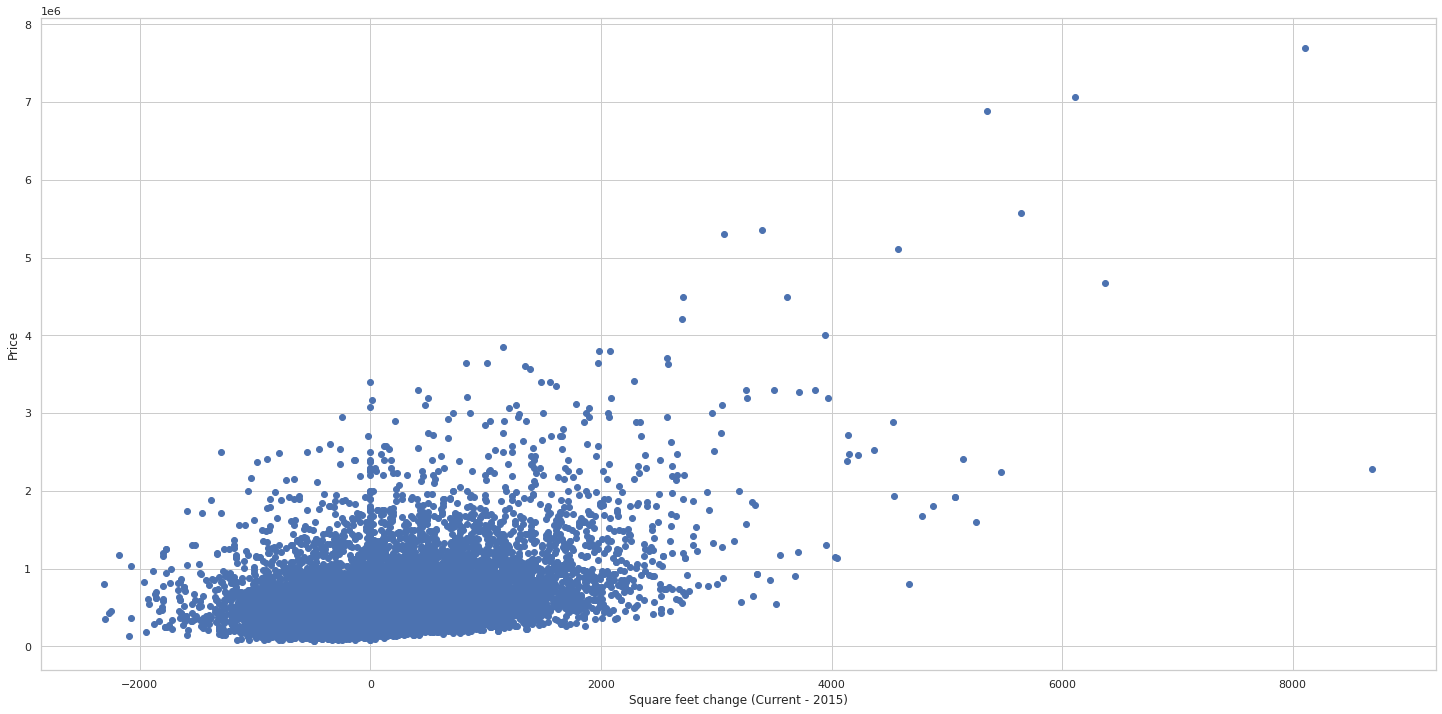

In [29]:
plt.scatter(x = 'sqft_living_change', y = 'price', data = df1)
plt.xlabel('Square feet change (Current - 2015)')
plt.ylabel('Price')

### 2.2 Basic Cleaning

In [30]:
city = []

for i in df1['city']:
    if i == 'SAMMAMIISH':
        city.append('SAMMAMISH')
    else:
        city.append(i)
    

In [31]:
df1['city'] = city

## 3.0 Exploratory Data Analysis

In [32]:
df2 = df1.copy()

### 3.1 Numerical Features

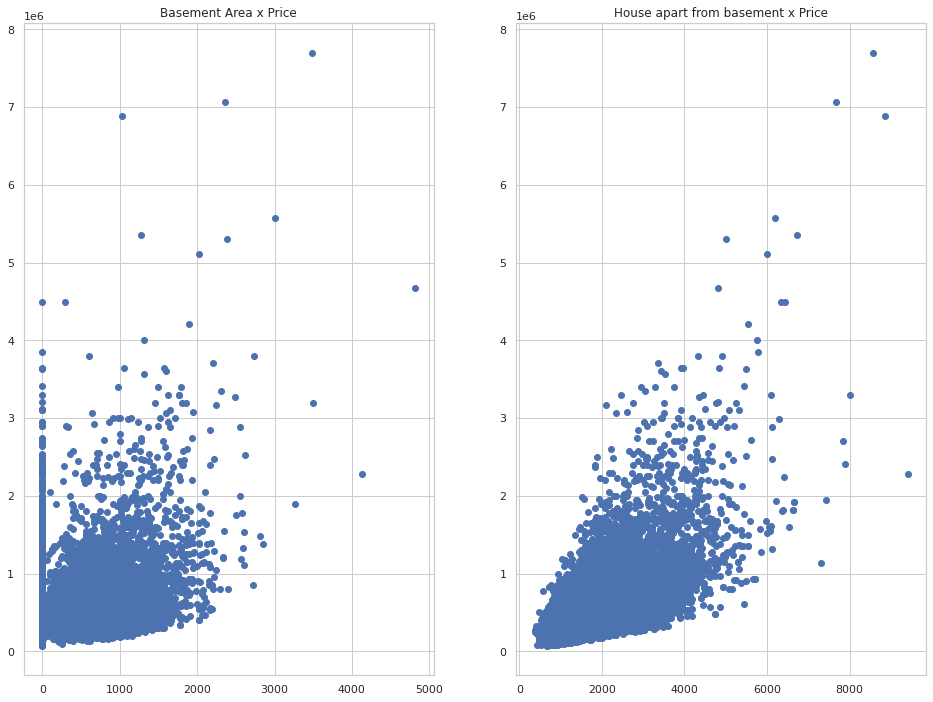

In [33]:
plt.subplot(1,3,1)
plt.scatter(x = 'sqft_basement', y = 'price', data = df2)
plt.title('Basement Area x Price')

plt.subplot(1,3,2)
plt.scatter(x = 'sqft_above', y = 'price', data = df2)
plt.title('House apart from basement x Price');

Due to **Multicolinearity** we will consider only the the square feet total area variable, instead of basement, lot and living room. These variables are part of **sqft_living** witch is the **total square footage of the home**.



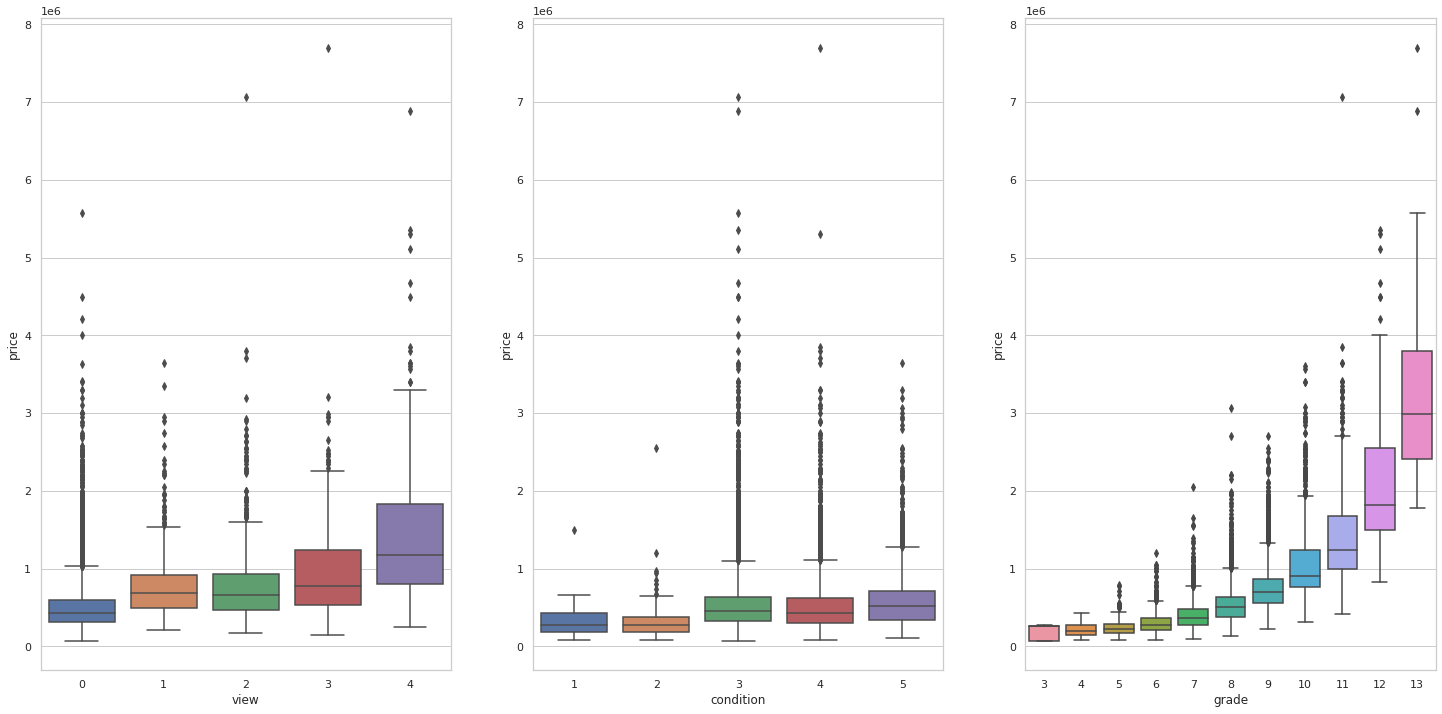

In [34]:
plt.subplot(1,3,1)
sns.boxplot(x = 'view', y = 'price', data = df2)

plt.subplot(1,3,2)
sns.boxplot(x = 'condition', y = 'price', data = df2)

plt.subplot(1,3,3)
sns.boxplot(x = 'grade', y = 'price', data = df2);

**Variação do preço por número de quartos, banheiros e andares**

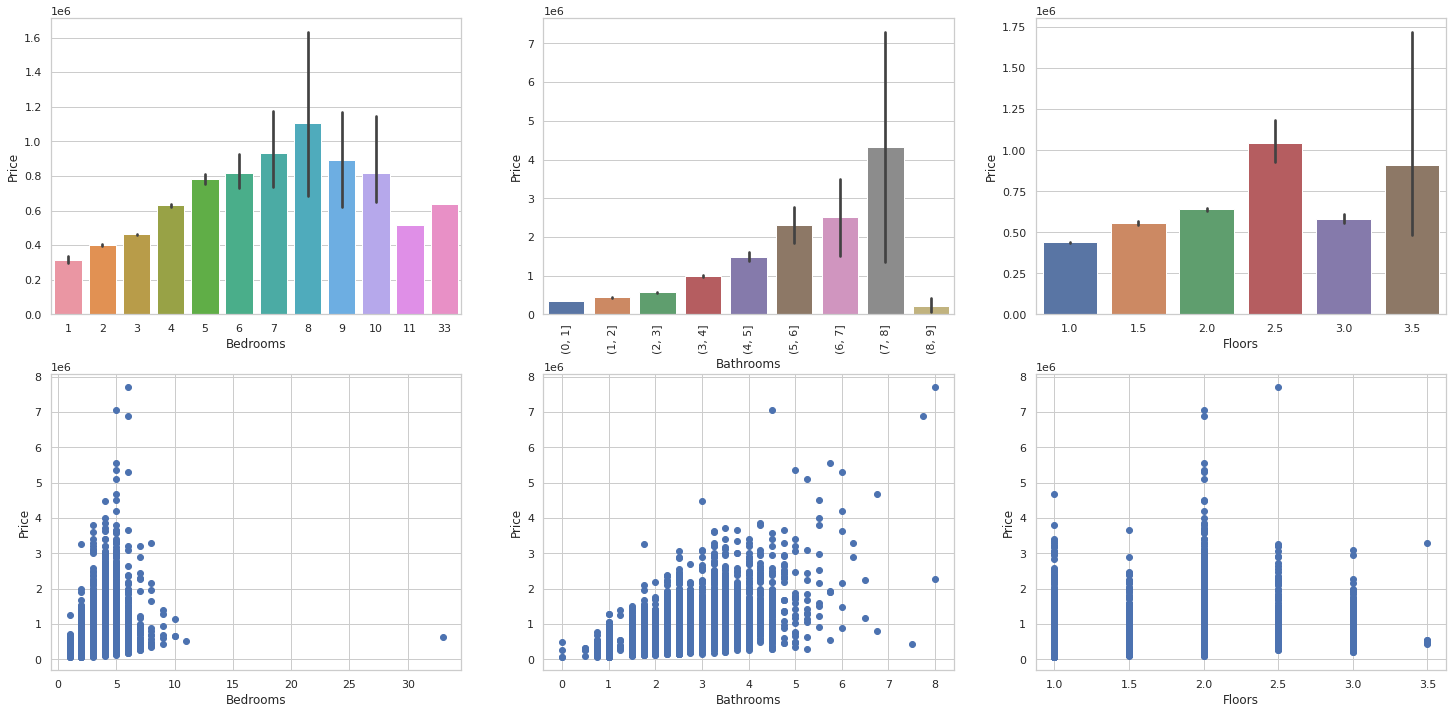

In [35]:
plt.subplot(2,3,1)
sns.barplot(x = 'bedrooms', y = 'price', data = df2)
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(2,3,2)
bins = list( np.arange( 0, 10, 1))
aux1 = df2.copy()
aux1['bathrooms_binned'] = pd.cut( df2['bathrooms'], bins = bins )
sns.barplot(x = 'bathrooms_binned', y = 'price', data = aux1)
plt.xticks( rotation=90 )
plt.xlabel('Bathrooms')
plt.ylabel('Price')


plt.subplot(2,3,3)
sns.barplot(x = 'floors', y = 'price', data = df2)
plt.xlabel('Floors')
plt.ylabel('Price')

plt.subplot(2,3,4)
plt.scatter(x = 'bedrooms', y = 'price', data = df2)
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(2,3,5)
plt.scatter(x = 'bathrooms', y = 'price', data = df2)
plt.xlabel('Bathrooms')
plt.ylabel('Price')

plt.subplot(2,3,6)
plt.scatter(x = 'floors', y = 'price', data = df2)
plt.xlabel('Floors')
plt.ylabel('Price');

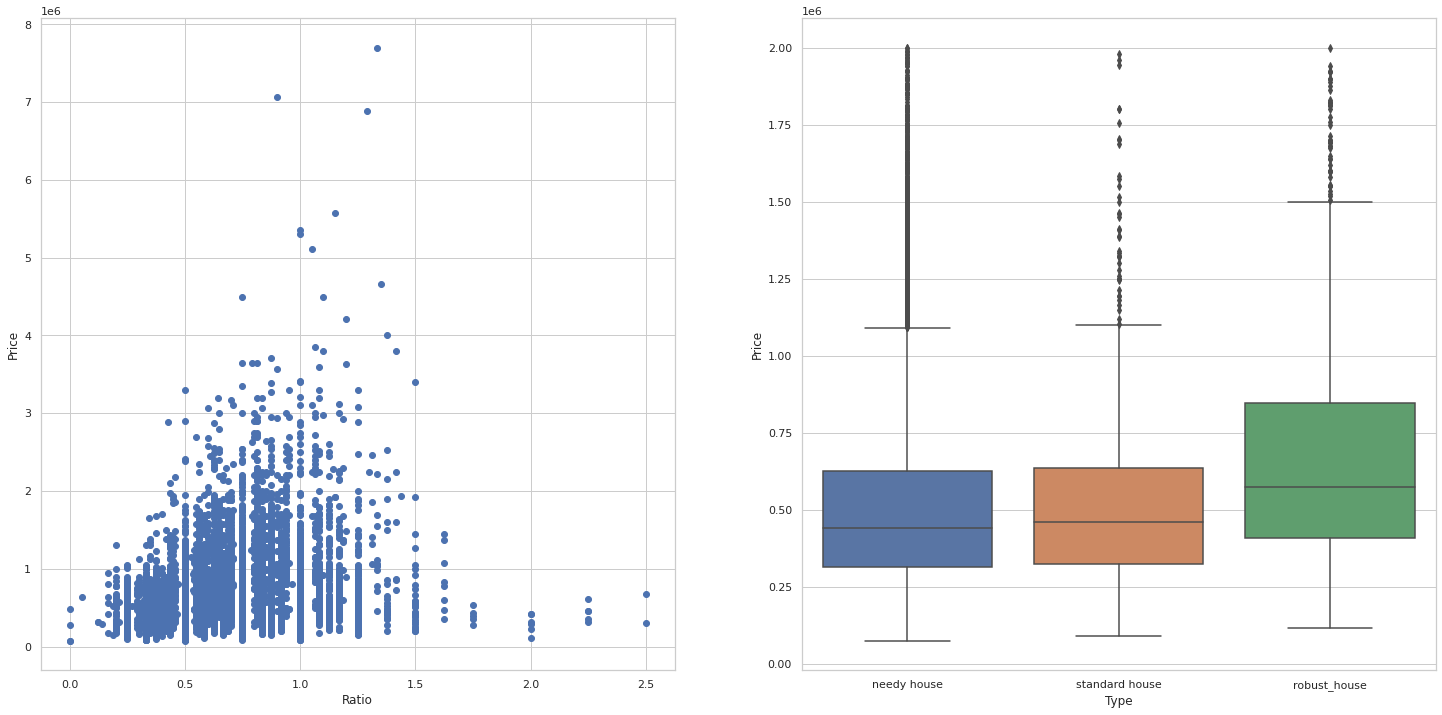

In [36]:
plt.subplot(1,2,1)
plt.scatter(x = 'house_ratio', y = 'price', data = df2)
plt.xlabel('Ratio')
plt.ylabel('Price')

plt.subplot(1,2,2)
aux1 = df2[( df2['price'] < 2000000)]
sns.boxplot(x = 'house_type', y = 'price', data = aux1)
plt.xlabel('Type')
plt.ylabel('Price');

The **house ratio** variable has definitely a relationship with price, but when transitioning from standard and needy houses to robust ones, this relationship seems stronger. 

In [37]:
df2['waterfront'] = df2['waterfront'].apply(lambda x: 'No' if x == 0 else 'Yes')
df2['waterfront'].value_counts()

No     22493
Yes      163
Name: waterfront, dtype: int64

**Waterfront**

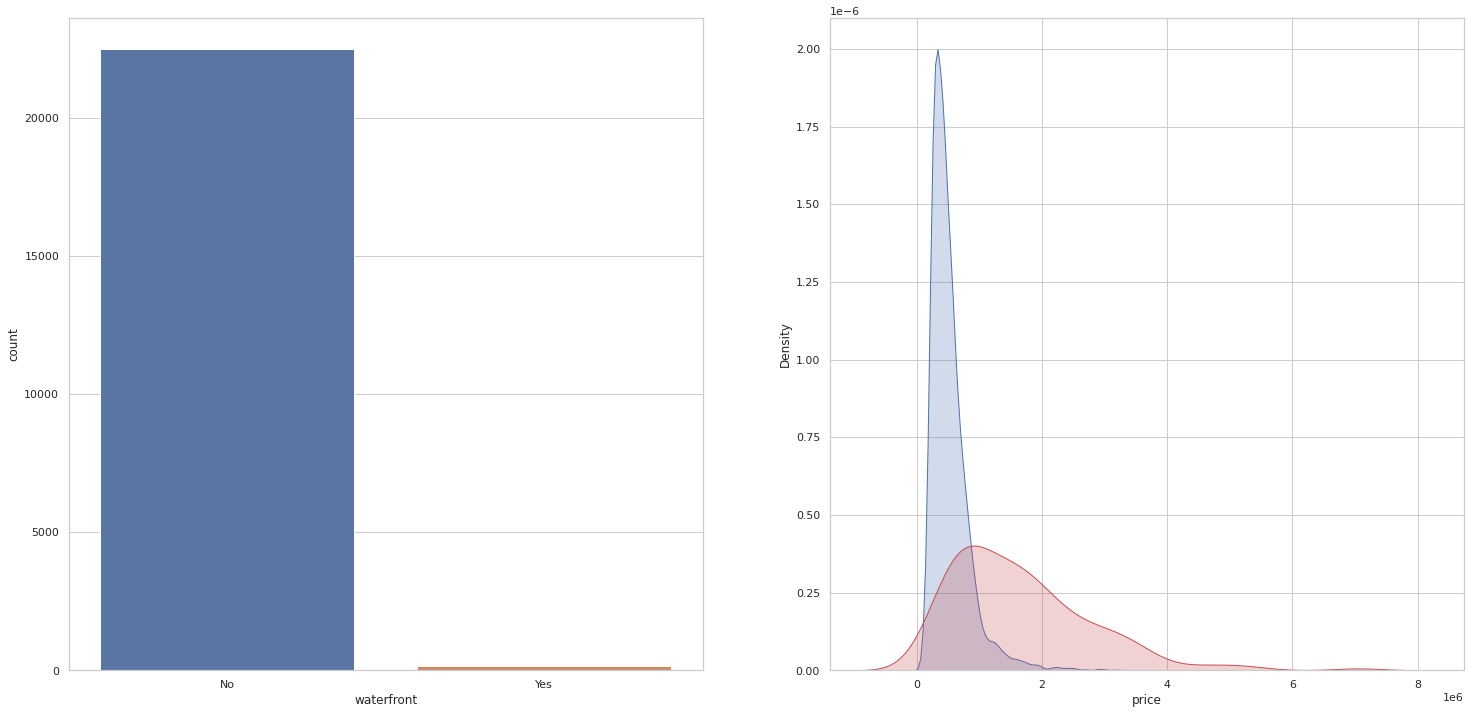

In [38]:
plt.subplot(1,2,1)
sns.countplot(x = 'waterfront', data = df2)

plt.subplot(1,2,2)
sns.kdeplot(df2[df2['waterfront']=='No']['price'],color='b',shade=True, legend = False)
sns.kdeplot(df2[df2['waterfront']=='Yes']['price'],color='r',shade=True, legend = False);

Residências na beira-mar, como esperado, são normalmente mais caras

**Square feet living / lot** + grade / view / condition

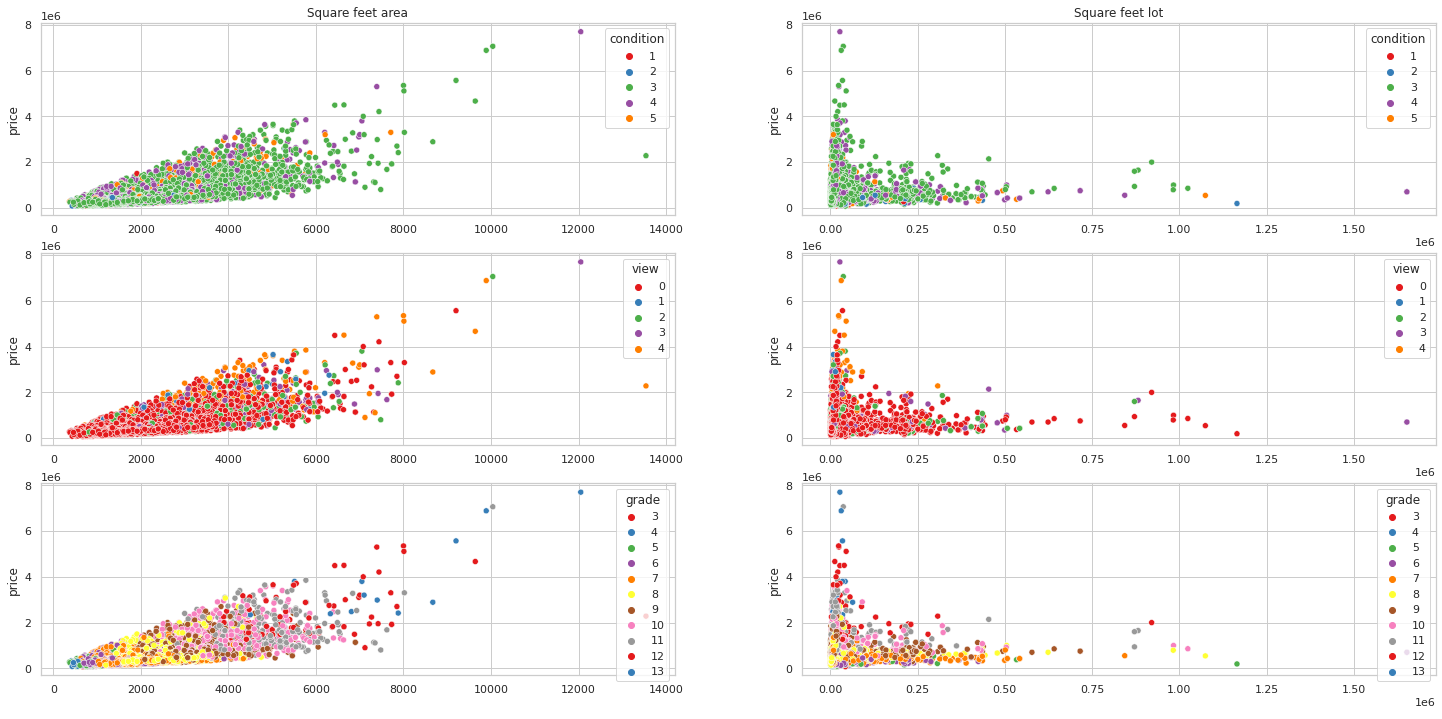

In [39]:
plt.subplot(3,2,1)
plt.title('Square feet area')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2, hue = 'condition', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,2)
plt.title('Square feet lot')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2, hue = 'condition', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,3)
plt.title(' ')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2, hue = 'view', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,4)
plt.title(' ')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2, hue = 'view', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,5)
plt.title(' ')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2, hue = 'grade', palette='Set1')
plt.xlabel(' ')


plt.subplot(3,2,6)
plt.title(' ')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2, hue = 'grade', palette='Set1')
plt.xlabel(' ');

In [96]:
df1['grade'].value_counts()

7     9335
8     6391
9     2800
6     2105
10    1207
11     431
5      248
12      94
4       27
13      13
3        5
Name: grade, dtype: int64

In [97]:
df1['view'].value_counts()

0    20448
2     1009
3      545
1      332
4      322
Name: view, dtype: int64

In [99]:
df1['condition'].value_counts()

3    14695
4     5991
5     1765
2      176
1       29
Name: condition, dtype: int64

**square feet living area** seems to have a strong relation with price, whereas the area of the lot, doesn't

**condition, view and grade** seems highly umbalanced 

**Square feet change**

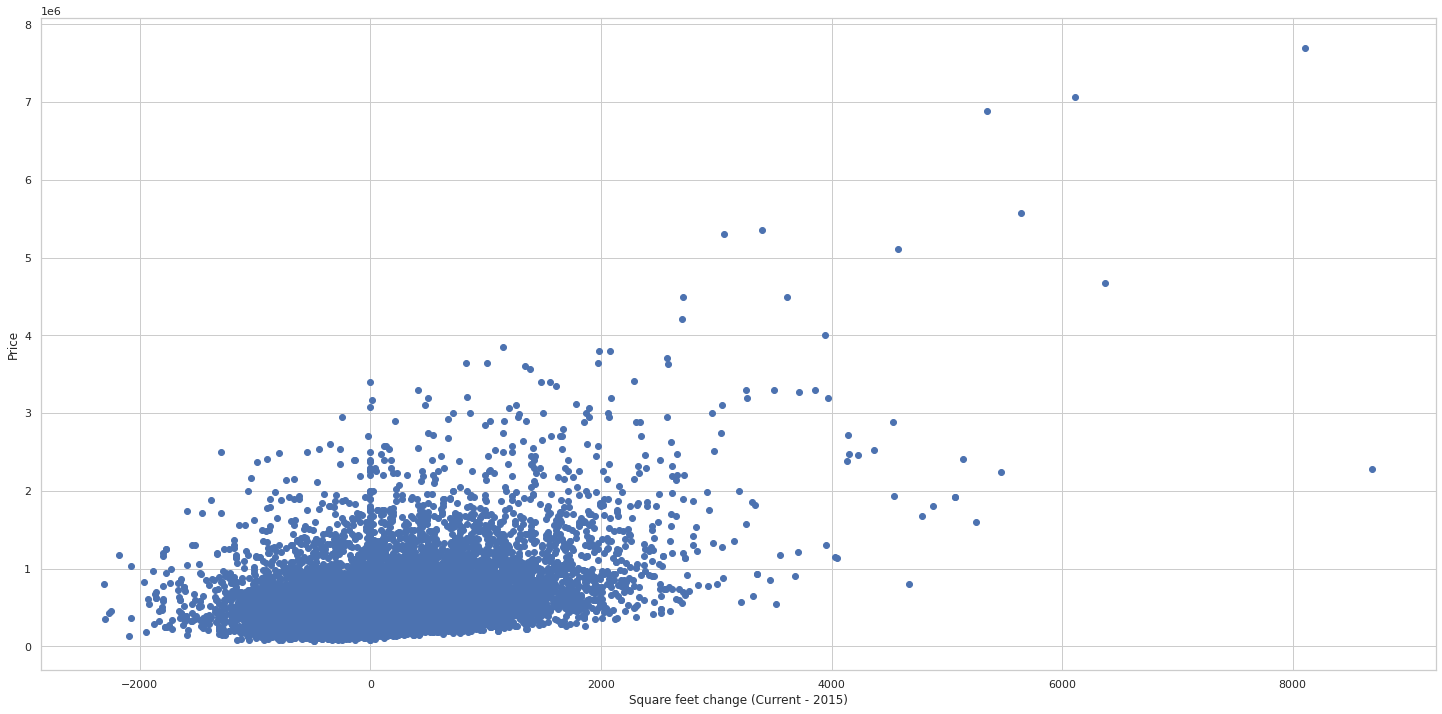

In [40]:
plt.scatter(x = 'sqft_living_change', y = 'price', data = df1)
plt.xlabel('Square feet change (Current - 2015)')
plt.ylabel('Price');

**Sales and time**

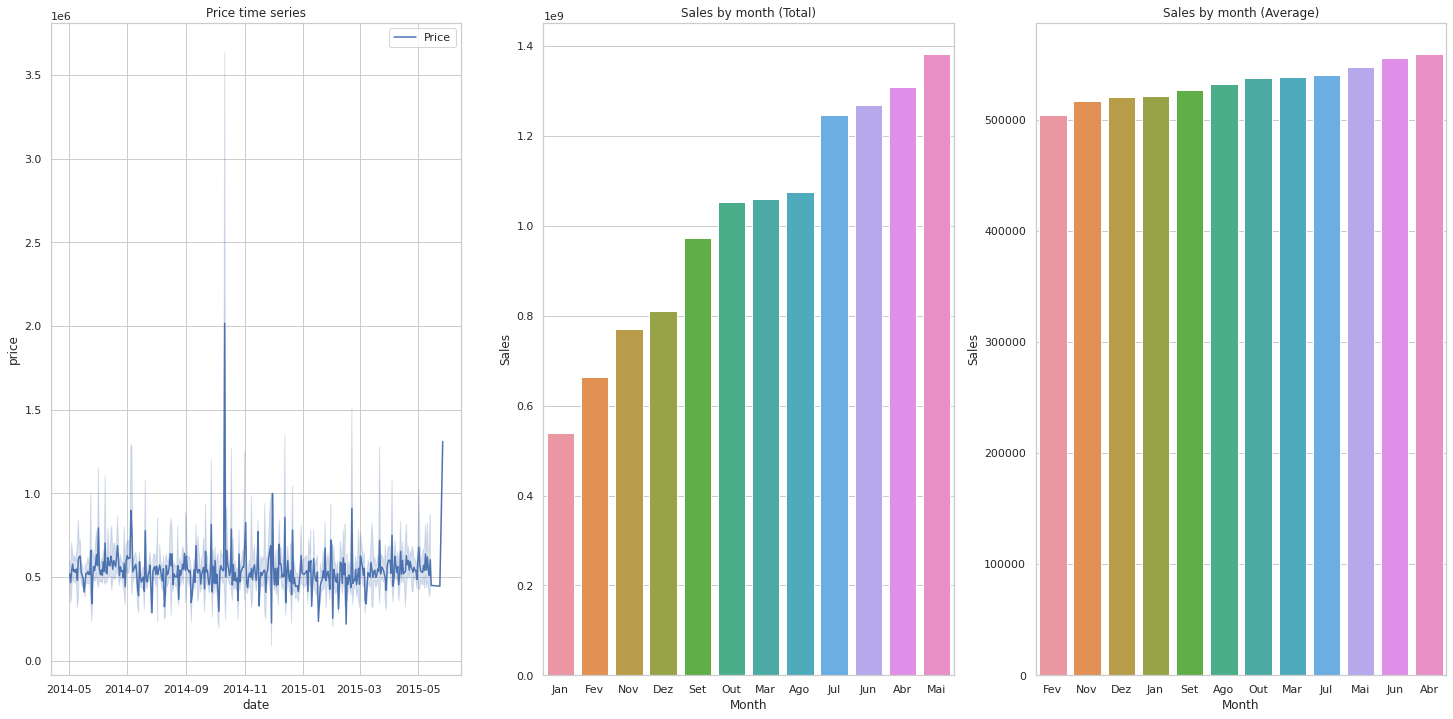

In [41]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=df2, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = df2[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data=aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = df2[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data=aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');

No varejo, normalmente as vendas são mais aquecidas no final do ano, nos mêses de Novembro e Dezembro. Vemos que o mercado de imóveis foge um pouco dessa regra, tendo **vendas médias maiores no começo para meio do ano, especificamente em Abril, Maio junho e Julho.** 

In [42]:
df2['month'].value_counts()

Mai    2525
Abr    2343
Jul    2307
Jun    2284
Ago    2022
Mar    1969
Out    1961
Set    1848
Dez    1556
Nov    1491
Fev    1316
Jan    1034
Name: month, dtype: int64

In [43]:
aux3.rename(columns = {'month':'Mês', 'price':'Média de vendas'}, inplace = True)
aux3.sort_values(by = ['Média de vendas'], ascending = False)

,Mês,Média de vendas
0,Abr,558897.250534
6,Jun,555339.725482
7,Mai,547393.763564
5,Jul,539937.047248
8,Mar,538439.869477
10,Out,537222.659867
1,Ago,531655.367953
11,Set,526317.120130
4,Jan,521003.038685
2,Dez,520646.304627


Alguns meses vendem menos, porém casas mais caras, o que, na média, faz com que todos os meses tenham um volume de venda aproximado, em torno de 500 mil por casa. Entretanto, **separaremos o dataset entre preços altos e baixos**, para tentar entender que mês vende casas mais caras ou mais baratas

In [44]:
df2['price'].describe()

count    2.265600e+04
mean     5.362740e+05
std      3.624995e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

Vemos que a mediana de preço é 450 mil dólares, valor que divide o conjunto de dados ordenados pelo preço ao meio. 

- 25% dos maiores valores são maiores que 645 mil dólares > **este será o conjunto de 'preços altos'**
- 25% dos menores valores são menores que 322 mil dólares > **este será o conjunto de 'preços baixos'**

In [45]:
aux_high_price = df2[df2['price'] > 644999] 
aux_high_price['price'].describe()

count    5.599000e+03
mean     9.808338e+05
std      4.698614e+05
min      6.450000e+05
25%      7.200000e+05
50%      8.250000e+05
75%      1.041445e+06
max      7.700000e+06
Name: price, dtype: float64

In [46]:
aux_low_price = df2[df2['price'] < 322000] 
aux_low_price['price'].describe()

count      5752.000000
mean     251718.606572
std       48035.915304
min       75000.000000
25%      220000.000000
50%      259000.000000
75%      290000.000000
max      321950.000000
Name: price, dtype: float64

**High Price**

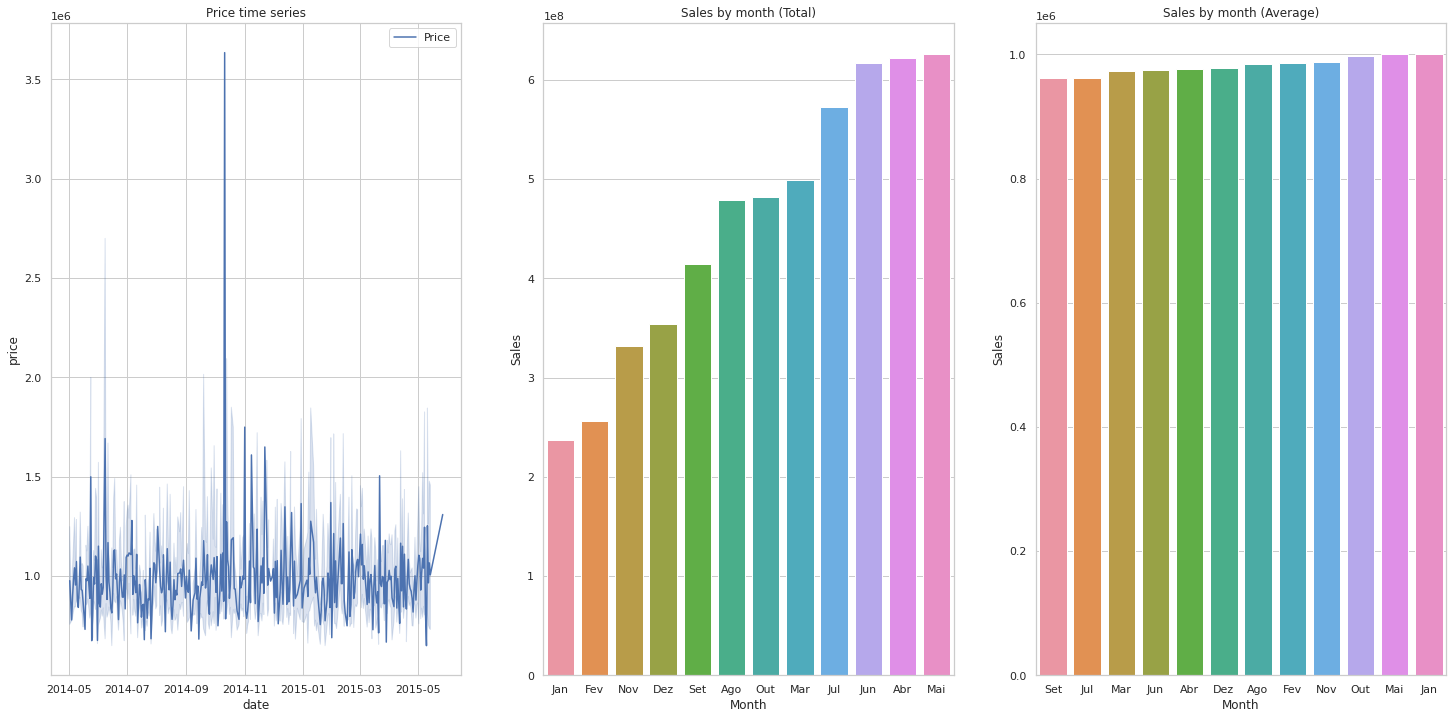

In [47]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=aux_high_price, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = aux_high_price[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data = aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = aux_high_price[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data = aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');

In [48]:
aux3.rename(columns = {'month':'Mês', 'price':'Média de vendas'}, inplace = True)
aux3.sort_values(by = ['Média de vendas'], ascending = False)

,Mês,Média de vendas
4,Jan,1.000604e+06
7,Mai,1.000109e+06
10,Out,9.974028e+05
9,Nov,9.876372e+05
3,Fev,9.865865e+05
1,Ago,9.848936e+05
2,Dez,9.774902e+05
0,Abr,9.762784e+05
6,Jun,9.754226e+05
8,Mar,9.733664e+05


Janeiro tem a menor quantidade de casas vendidas, porém, a segunda maior média de venda considerando as casas mais caras. Portanto, **Principalmente Janeiro**, mas também Fevereiro e Novembro tem comportamento parecido. 

**Low Price**

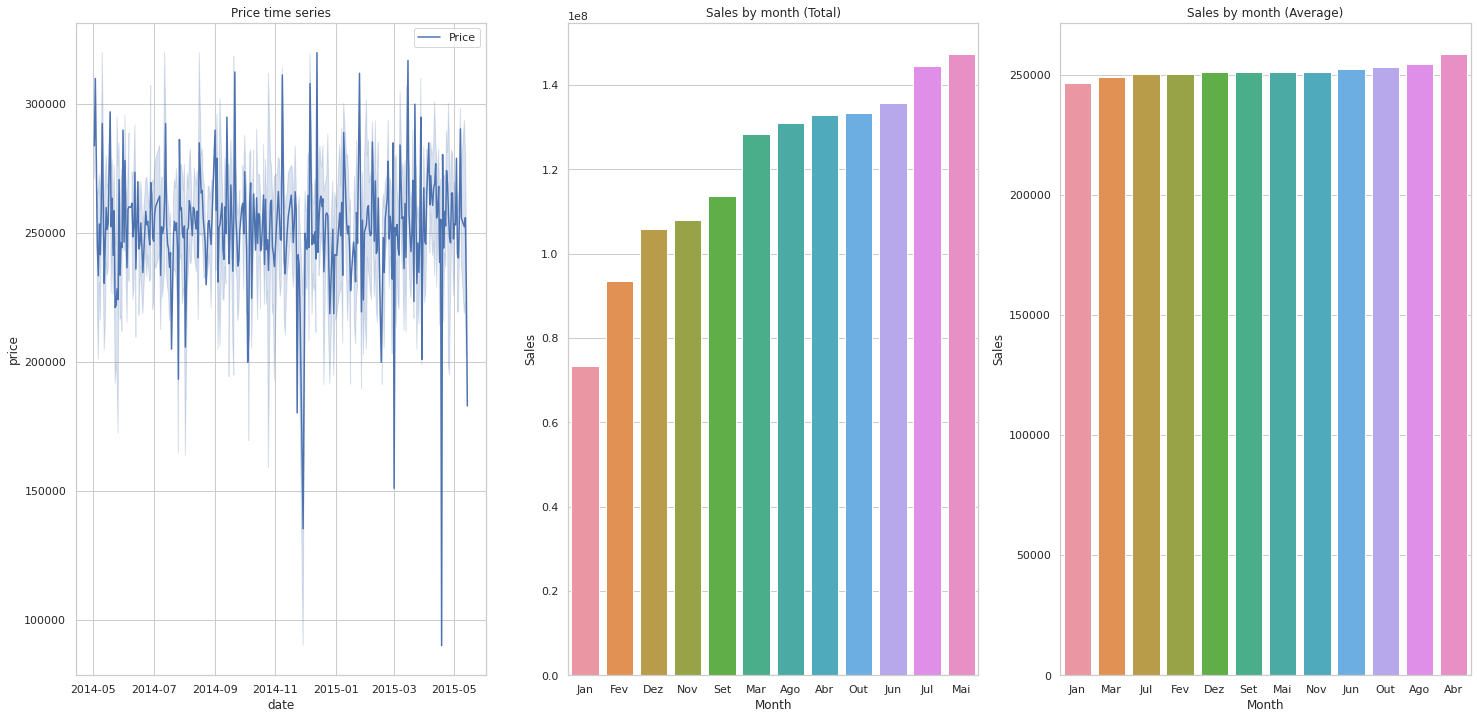

In [49]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=aux_low_price, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = aux_low_price[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data = aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = aux_low_price[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data = aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');

In [50]:
aux3.rename(columns = {'month':'Mês', 'price':'Média de vendas'}, inplace = True)
aux3.sort_values(by = ['Média de vendas'], ascending = False)

,Mês,Média de vendas
0,Abr,258548.188716
1,Ago,254327.405825
10,Out,253257.751423
6,Jun,252121.786245
9,Nov,251042.025581
7,Mai,251010.848382
11,Set,250934.339956
2,Dez,250879.810427
3,Fev,250128.328877
5,Jul,250102.266436


**October, August and April** sell the most low price houses. As we should expect, **January** sell less of these houses

### 3.2 Location 

As mentioned before, with the zipcode, we was able to gather data from cities, and merge to the existing dataframe. Doing that, now we are able to see **sellings across the cities**. 

In [51]:
df2['city'].value_counts()

SEATTLE          8973
RENTON           1597
BELLEVUE         1407
AUBURN           1262
KENT             1201
REDMOND           978
KIRKLAND          977
WOODINVILLE       942
SAMMAMISH         800
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      589
ENUMCLAW          468
SNOQUALMIE        308
KENMORE           283
MERCER ISLAND     282
NORTH BEND        221
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            117
BLACK DIAMOND     100
FALL CITY          80
MEDINA             50
Name: city, dtype: int64

**Total Sales / Average Sales by City**

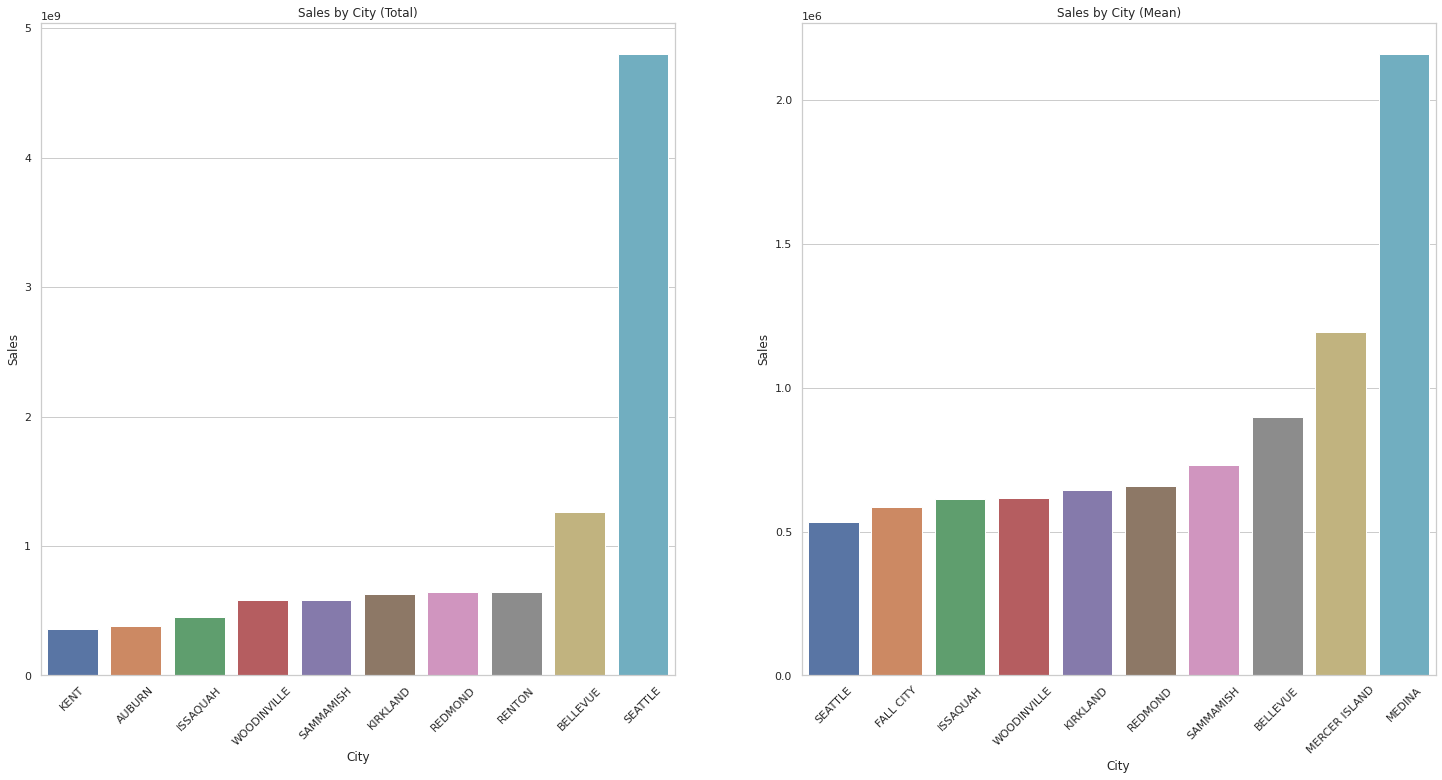

In [52]:
plt.subplot(1,2,1)
aux4 = df2[['price', 'city']].groupby('city').sum().reset_index()
sns.barplot( x='city', y='price', data= aux4.sort_values(['price']).tail(10), label='Price' )
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Sales')
plt.title('Sales by City (Total)');

plt.subplot(1,2,2)
aux5 = df2[['price', 'city']].groupby('city').mean().reset_index()
sns.barplot( x='city', y='price', data= aux5.sort_values(['price']).tail(10), label='Price' )
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Sales')
plt.title('Sales by City (Mean)');

In [53]:
aux5.rename(columns = {'city':'Cidade', 'price':'Média de vendas'}, inplace = True)
aux5.sort_values(by = ['Média de vendas'], ascending = False)

,Cidade,Média de vendas
14,MEDINA,2.160607e+06
15,MERCER ISLAND,1.194230e+06
1,BELLEVUE,8.981876e+05
19,SAMMAMISH,7.327115e+05
17,REDMOND,6.582037e+05
12,KIRKLAND,6.463742e+05
23,WOODINVILLE,6.173845e+05
9,ISSAQUAH,6.150913e+05
7,FALL CITY,5.860084e+05
20,SEATTLE,5.349804e+05


### 3.3 Multivariate Analysis

**Heatmap**

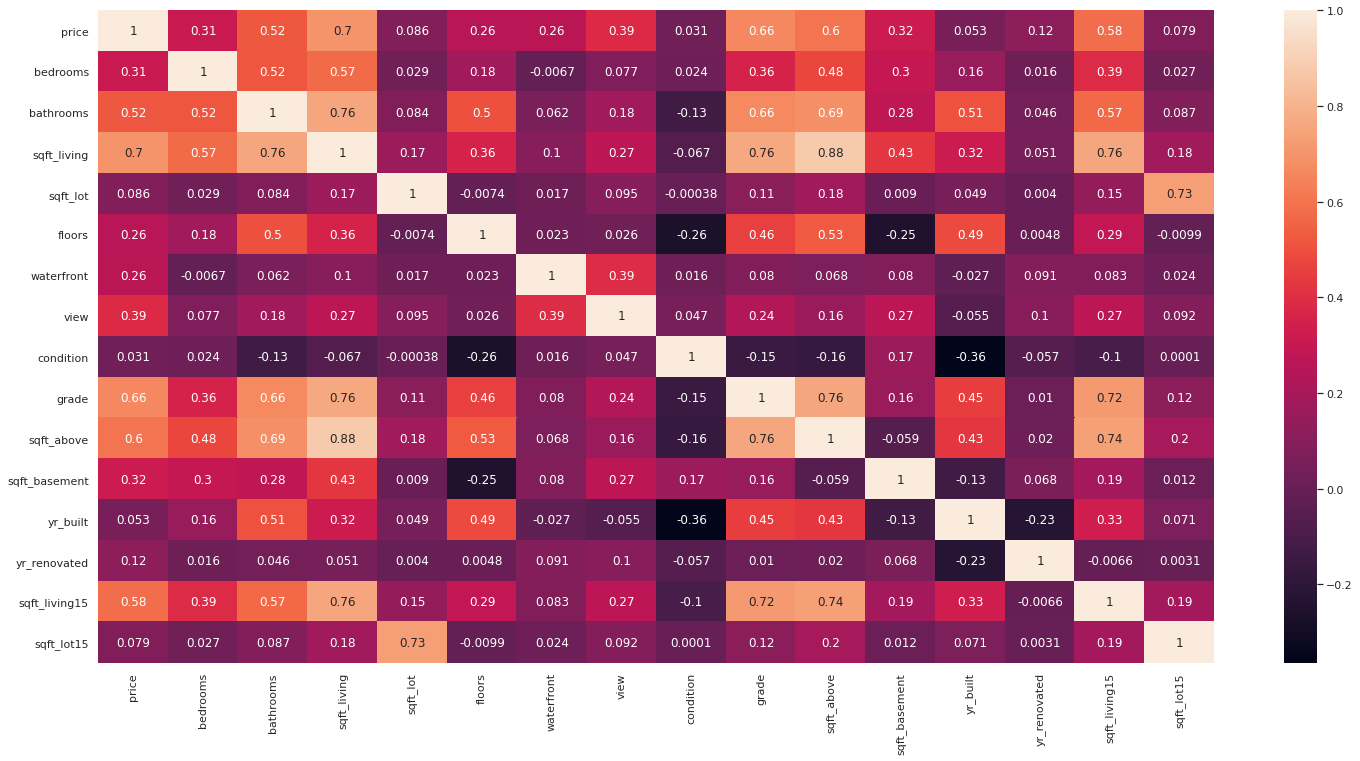

In [54]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

## 4.0 Data Preparation

In order to proceed with the analysis, we need to first handle the outliers, once we're gonna infer prices from features using a linear model. 

### 4.1 Handling with outliers using IQR.

**IQR or interquartile range** 
is a measurement of variability built on dividing the dataset into different counties. Counties are broken down in Q1, Q2, and Q3, where Q1 is the middle value of the first half of the dataset. Q2 is the median value, and Q3 is the middle value of the second half of the dataset.


After computing IQR, we calculate **the lower limit and upper limit** and then simply discard all the values that are less or above the limit and replace them with lower and upper limit consequently.¶

In [112]:
df3 = df2.copy()

#### Price

In [113]:
Q1 = df3['price'].quantile(0.25)
Q3 = df3['price'].quantile(0.75)
print('Q1:',Q1)
print('Q3: ',Q3)

IQR = Q3-Q1
print('IQR: ',IQR)

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Lower limit: ',lower_limit)
print('Upper limit: ',upper_limit)

df3['price'] = np.where(df3['price']>upper_limit,upper_limit,df3['price'])
df3['price'] = np.where(df3['price']<lower_limit,lower_limit,df3['price'])

Q1: 320000.0
Q3:  640000.0
IQR:  320000.0
Lower limit:  -160000.0
Upper limit:  1120000.0


/home/jvbf/anaconda3/envs/house-sales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

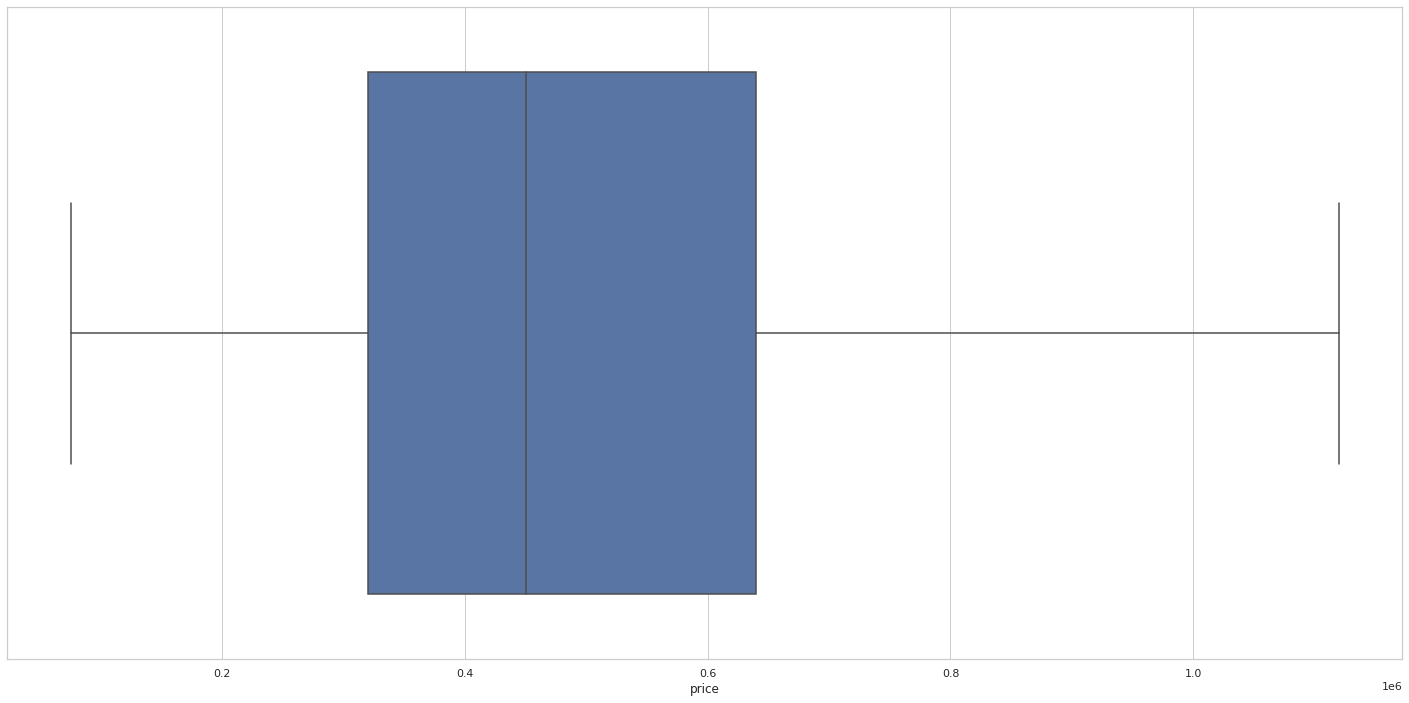

In [114]:
sns.boxplot(df3['price'])

Last, we're going to use de natural logarithm of price, due to interpretation improvements

In [115]:
df3['price'] = np.log1p(df3['price'])

<AxesSubplot:>

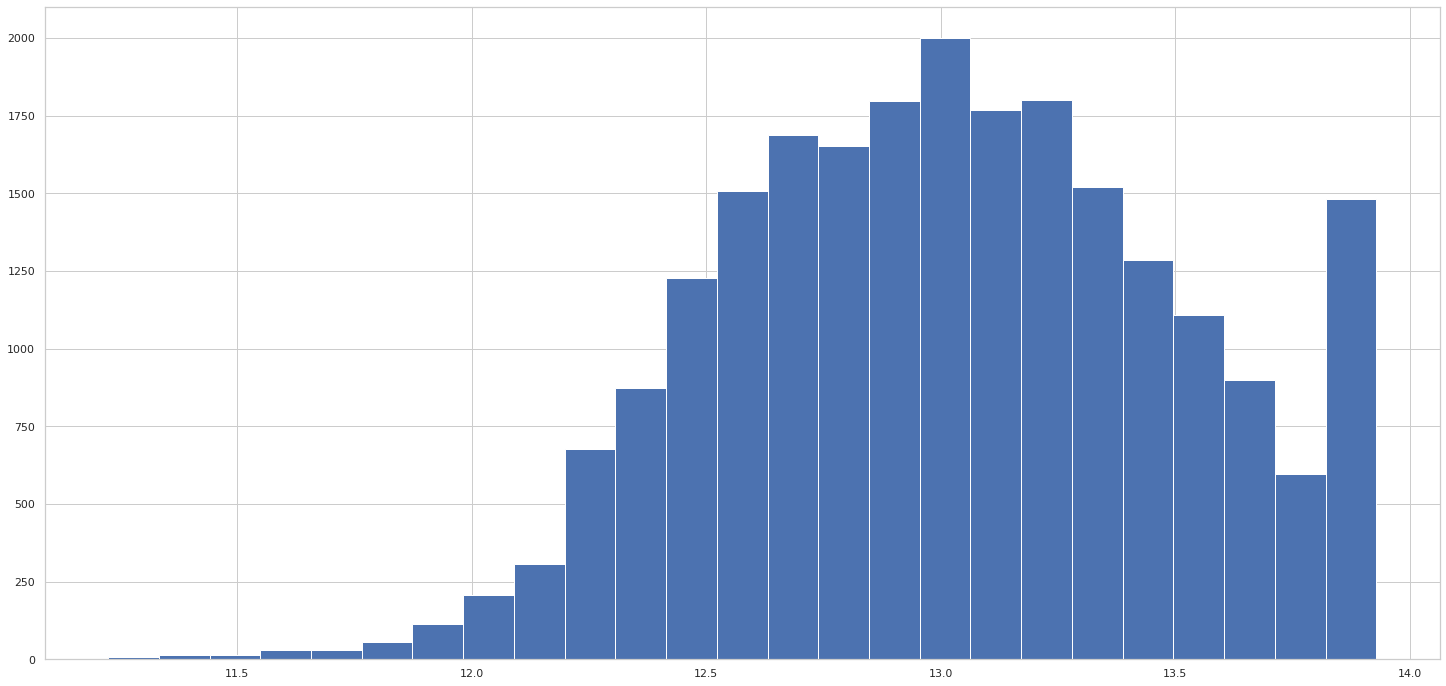

In [116]:
df3['price'].hist(bins = 25)

### 4.2 Categorical Variables

In [117]:
df3 = pd.get_dummies(df3 ,columns=['city', 'month'])
df3.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,house_ratio,house_type,sqft_living_change,city_AUBURN,city_BELLEVUE,city_BLACK DIAMOND,city_BOTHELL,city_CARNATION,city_DUVALL,city_ENUMCLAW,city_FALL CITY,city_FEDERAL WAY,city_ISSAQUAH,city_KENMORE,city_KENT,city_KIRKLAND,city_MAPLE VALLEY,city_MEDINA,city_MERCER ISLAND,city_NORTH BEND,city_REDMOND,city_RENTON,city_SAMMAMISH,city_SEATTLE,city_SNOQUALMIE,city_VASHON,city_WOODINVILLE,month_Abr,month_Ago,month_Dez,month_Fev,month_Jan,month_Jul,month_Jun,month_Mai,month_Mar,month_Nov,month_Out,month_Set
0,7129300520,2014-10-13,12.309987,3,1.00,1180,5650,1.0,No,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,0.333333,needy house,-160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4060000240,2014-06-23,12.232841,2,1.00,880,6780,1.0,No,0,4,6,880,0,1945,0,98178,47.5009,-122.248,1190,6780,2014,0.500000,needy house,-310,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,4058801670,2014-07-17,13.005832,3,2.25,2100,8201,1.0,No,2,3,8,1620,480,1967,0,98178,47.5091,-122.244,2660,8712,2014,0.750000,needy house,-560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2976800796,2014-09-25,12.371591,3,1.00,1300,5898,1.0,No,0,3,7,1300,0,1961,0,98178,47.5053,-122.255,1320,7619,2014,0.333333,needy house,-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6874200960,2015-02-27,12.043560,2,1.00,860,5265,1.0,No,0,3,6,860,0,1931,0,98178,47.5048,-122.272,1650,8775,2015,0.500000,needy house,-790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [118]:
df3['waterfront'] = df3['waterfront'].apply(lambda x: 1 if x == 'Yes' else 0)

## 5.0 Modeling

In [119]:
df4 = df3.copy()

In [120]:
import statsmodels.api as sm

In [121]:
df4.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,house_ratio,house_type,sqft_living_change,city_AUBURN,city_BELLEVUE,city_BLACK DIAMOND,city_BOTHELL,city_CARNATION,city_DUVALL,city_ENUMCLAW,city_FALL CITY,city_FEDERAL WAY,city_ISSAQUAH,city_KENMORE,city_KENT,city_KIRKLAND,city_MAPLE VALLEY,city_MEDINA,city_MERCER ISLAND,city_NORTH BEND,city_REDMOND,city_RENTON,city_SAMMAMISH,city_SEATTLE,city_SNOQUALMIE,city_VASHON,city_WOODINVILLE,month_Abr,month_Ago,month_Dez,month_Fev,month_Jan,month_Jul,month_Jun,month_Mai,month_Mar,month_Nov,month_Out,month_Set
0,7129300520,2014-10-13,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,0.333333,needy house,-160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4060000240,2014-06-23,12.232841,2,1.00,880,6780,1.0,0,0,4,6,880,0,1945,0,98178,47.5009,-122.248,1190,6780,2014,0.500000,needy house,-310,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,4058801670,2014-07-17,13.005832,3,2.25,2100,8201,1.0,0,2,3,8,1620,480,1967,0,98178,47.5091,-122.244,2660,8712,2014,0.750000,needy house,-560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2976800796,2014-09-25,12.371591,3,1.00,1300,5898,1.0,0,0,3,7,1300,0,1961,0,98178,47.5053,-122.255,1320,7619,2014,0.333333,needy house,-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6874200960,2015-02-27,12.043560,2,1.00,860,5265,1.0,0,0,3,6,860,0,1931,0,98178,47.5048,-122.272,1650,8775,2015,0.500000,needy house,-790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [123]:
X = df4.drop(['id', 'date','yr_built','sqft_basement', 'yr_renovated', 'price', 'sqft_lot','zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'house_type'], axis = 1)
y = df4['price']

In [124]:
inpc=sm.add_constant(X)
ols=sm.OLS(y,inpc)
ols_mod=ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1377.
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:45:43   Log-Likelihood:                -708.86
No. Observations:               22656   AIC:                             1510.
Df Residuals:                   22610   BIC:                             1879.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.8064      0.021    472.030      0.000       9.766       9.847
bedrooms               0.0346      0.005      7.673      0.000       0.026       0.043
bathrooms             -0.0252      0.008     -3.278      0.001      -0.040      -0.010
sqft_living            0.0002   6.12e-06     38.405      0.000       0.000       0.000
floors                 0.0535      0.004     12.169      0.000       0.045       0.062
waterfront             0.0784      0.022      3.605      0.000       0.036       0.121
view                   0.0374      0.003     14.394      0.000       0.032       0.043
condition              0.0869      0.003     31.789      0.000       0.082       0.092
grade                  0.1217      0.003     47.082      0.000       0.117       0.127
sqft_above         -1.243e-05   5.38e-06     -2.310      0.021    -2.3e-05   -1.88e-06
house_ratio            0.1741      0.023      7.693      0.000       0.130       0.218
sqft_living_change    -0.0001   4.28e-06    -25.496      0.000      -0.000      -0.000
city_AUBURN            0.0268      0.008      3.557      0.000       0.012       0.042
city_BELLEVUE          0.6800      0.007     90.683      0.000       0.665       0.695
city_BLACK DIAMOND     0.3010      0.024     12.432      0.000       0.254       0.348
city_BOTHELL           0.4576      0.018     26.149      0.000       0.423       0.492
city_CARNATION         0.3779      0.022     17.335      0.000       0.335       0.421
city_DUVALL            0.3574      0.018     20.167      0.000       0.323       0.392
city_ENUMCLAW          0.1125      0.012      9.588      0.000       0.089       0.135
city_FALL CITY         0.4921      0.027     18.215      0.000       0.439       0.545
city_FEDERAL WAY      -0.0036      0.009     -0.394      0.693      -0.022       0.014
city_ISSAQUAH          0.5191      0.010     54.279      0.000       0.500       0.538
city_KENMORE           0.4255      0.015     29.066      0.000       0.397       0.454
city_KENT              0.0575      0.008      7.472      0.000       0.042       0.073
city_KIRKLAND          0.6271      0.008     74.808      0.000       0.611       0.644
city_MAPLE VALLEY      0.1803      0.010     17.258      0.000       0.160       0.201
city_MEDINA            0.7337      0.034     21.409      0.000       0.667       0.801
city_MERCER ISLAND     0.7271      0.015     48.531      0.000       0.698       0.756
city_NORTH BEND        0.3803      0.016     23.098      0.000       0.348       0.413
city_REDMOND           0.6151      0.008     72.864      0.000       0.599       0.632
city_RENTON            0.2527      0.007     36.831      0.000       0.239       0.266
city_SAMMAMISH         0.5438      0.009     58.105      0.000       0.525       0.562
city_SEATTLE           0.5672      0.0